__1. Обучить алгоритмы LightGBM, XGBoost и CatBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.__

In [92]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

In [106]:
path_dir = "data/competition_data/"

train = pd.read_csv(path_dir + "train.csv")
test = pd.read_csv(path_dir + "test.csv")
bki = pd.read_csv(path_dir + "bki.csv")
client_profile = pd.read_csv(path_dir + "client_profile.csv")
payments = pd.read_csv(path_dir + "payments.csv")

In [107]:
def simple_merge_dfs(df):
    df = df.merge(bki, how="left", on="APPLICATION_NUMBER")
    df = df.merge(client_profile, how="left", on="APPLICATION_NUMBER")
    df = df.merge(payments, how="left", on="APPLICATION_NUMBER")
    return df

In [108]:
train = simple_merge_dfs(train).sample(30000).reset_index()
test = simple_merge_dfs(test).sample(30000).reset_index()

print(f"Train.shape = {train.shape}")
print(f"Test.shape = {test.shape}")

Train.shape = (30000, 50)
Test.shape = (30000, 49)


In [109]:
train.head()

,index,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,428167,123703256,0,Cash,5628273.0,Sold,currency 1,2839.0,0.0,2523.0,...,0.0,0.0,2.0,49432906.0,3.0,8.0,234.0,235.0,10939.725,10939.725
1,341772,123709278,0,Cash,6327592.0,Closed,currency 1,702.0,0.0,519.0,...,NaN,NaN,NaN,49301614.0,1.0,24.0,103.0,109.0,29677.500,29677.500
2,241500,123507549,0,Cash,5131118.0,Active,currency 1,822.0,0.0,512.0,...,NaN,NaN,NaN,48893223.0,1.0,6.0,1441.0,1513.0,5414.310,5414.310
3,961521,123557715,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,49387262.0,1.0,5.0,173.0,184.0,11385.630,11385.630
4,194448,123469381,0,Cash,5743952.0,Active,currency 1,987.0,0.0,840.0,...,0.0,1.0,7.0,49333046.0,1.0,10.0,256.0,256.0,39087.450,39087.450


In [148]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if categorical:
        X[categorical] = X[categorical].astype('category')

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=0, early_stopping_rounds=5000,
#             categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
    print("=" * 30)
    print(time.ctime())
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores, encoders = [], [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    print("=" * 30)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=0
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)
        folds_scores.append(score)
    print("=" * 30)
    print(time.ctime())
    return estimators, encoders, oof_preds


def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)], 
            silent=True
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
    print("=" * 30)
    print(time.ctime())
    return estimators, oof_preds

In [111]:
lgb_params = {
    'boosting_type': 'goss',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [145]:
cv = KFold(n_splits=6, random_state=435, shuffle=True)
target_train, data_train = train["TARGET"], train.drop(["APPLICATION_NUMBER", "TARGET"], axis=1)
data_test = test.drop(["APPLICATION_NUMBER"], axis=1)

In [113]:
categorical_features = data_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [114]:
estimators_lgb, oof_preds_lgb = lightgbm_cross_validation(lgb_params, 
                                                          data_train, 
                                                          target_train, 
                                                          cv, 
                                                          categorical=categorical_features)

Wed Dec 16 17:29:03 2020, Cross-Validation, 30000 rows, 48 cols
Fold 1, Valid score = 0.78224
Fold 2, Valid score = 0.79029
Fold 3, Valid score = 0.82533
Fold 4, Valid score = 0.78035
Fold 5, Valid score = 0.80743
Fold 6, Valid score = 0.79883
Fold 7, Valid score = 0.80506
Fold 8, Valid score = 0.76987
Fold 9, Valid score = 0.78919
Fold 10, Valid score = 0.75653


In [149]:
estimators_xgb, encoders_xgb, oof_preds_xgb = xgboost_cross_validation(xgb_params,
                                                                       data_train,
                                                                       target_train,
                                                                       cv,
                                                                       categorical=categorical_features)

Wed Dec 16 18:24:57 2020, Cross-Validation, 30000 rows, 48 cols
Fold 1, Valid score = 0.74236
Fold 2, Valid score = 0.72908
Fold 3, Valid score = 0.75349
Fold 4, Valid score = 0.75275
Fold 5, Valid score = 0.75508
Fold 6, Valid score = 0.72076
Wed Dec 16 18:25:37 2020


In [116]:
estimators_cb, oof_preds_cb = catboost_cross_validation(cb_params,
                                                        data_train,
                                                        target_train,
                                                        cv,
                                                        categorical=categorical_features)

Wed Dec 16 17:31:13 2020, Cross-Validation, 30000 rows, 48 cols
Fold 1, Valid score = 0.7592
Fold 2, Valid score = 0.69637
Fold 3, Valid score = 0.78079
Fold 4, Valid score = 0.74811
Fold 5, Valid score = 0.78063
Fold 6, Valid score = 0.75906
Fold 7, Valid score = 0.76317
Fold 8, Valid score = 0.6841
Fold 9, Valid score = 0.73924
Fold 10, Valid score = 0.73441


In [119]:
scores_train = pd.DataFrame({
    "lgbm": oof_preds_lgb,
    "xgb": oof_preds_xgb,
    "cb" :oof_preds_cb,
})

corr = scores_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

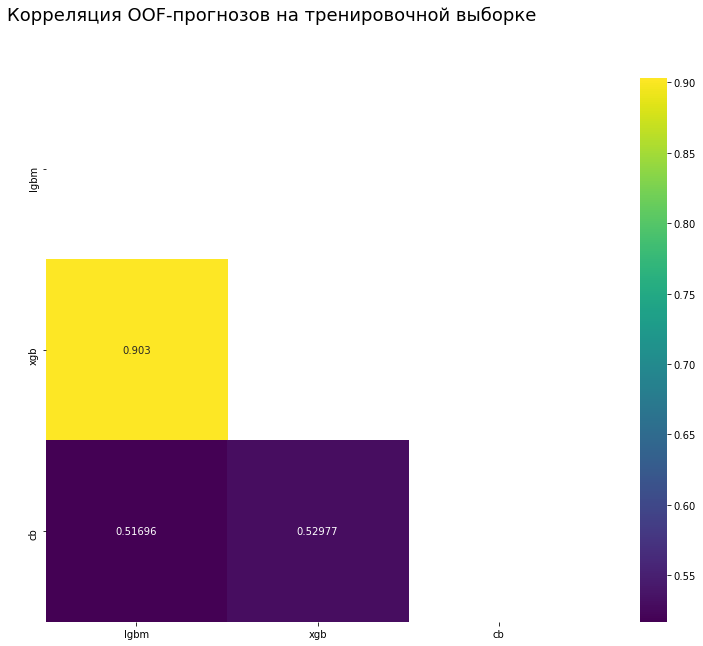

In [131]:
fig, axes = plt.subplots(1, 1, figsize=(18, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".5g", square=True, cmap="viridis", ax=axes)
fig.suptitle("Корреляция OOF-прогнозов на тренировочной выборке", fontsize=18);

In [244]:
def get_df_lgb_predictions(df, categorical_features=None):
    df[categorical_features] = df[categorical_features].astype('category')
    
    return df


def get_df_xgb_predictions(df, categorical_features=None, encoders=None):

    for (feature, encoder) in encoders.items():
        encoder_dict = dict(zip(encoder.classes_, encoder.transform(le.classes_)))
        
        df[feature] = df[feature].astype("str").fillna("NA")
        print(encoder_dict)
        df[feature][[elm not in encoder_dict.values() for elm in df[feature].values]] = "NA"
        
        df[feature] = encoder.transform(df[feature])
    return xgb.DMatrix(df)

In [172]:
fig_train_x = get_df_lgb_predictions(data_train, categorical_features=categorical_features)

lgb_scores = {f"lgb_{n}-estimator": estimator.predict_proba(fig_train_x)[:, 1] for n, estimator in enumerate(estimators_lgb)}

In [173]:
fig_train_x = get_df_xgb_predictions(data_train, categorical_features=categorical_features, encoders=encoders_xgb)

xgb_scores = {f"xgb_{n}-estimator": estimator.predict(fig_train_x) for n, estimator in enumerate(estimators_xgb)}

In [174]:
cb_scores = {f"cb_{n}-estimator": estimator.predict_proba(data_train)[:, 1] for n, estimator in enumerate(estimators_cb)}

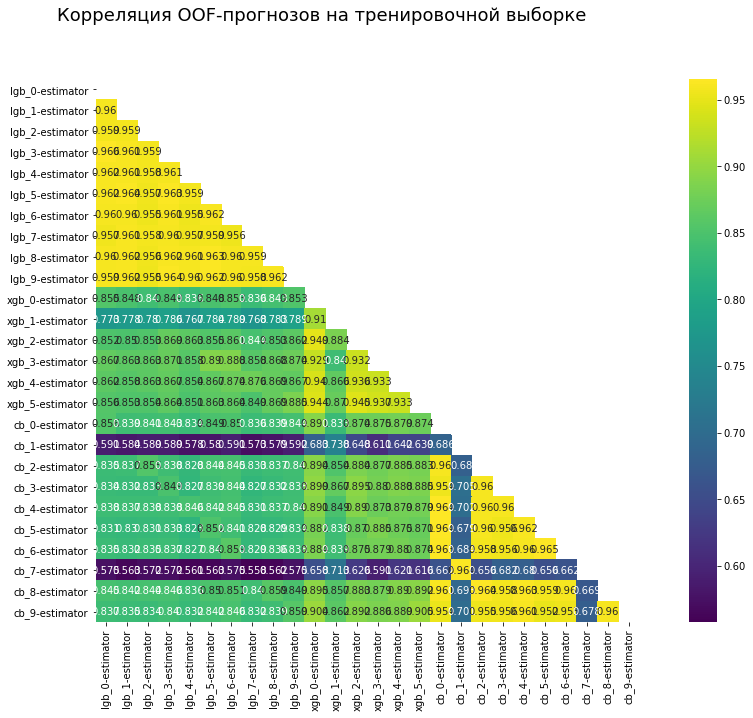

In [177]:
concat_scores = {}
concat_scores.update(lgb_scores)
concat_scores.update(xgb_scores)
concat_scores.update(cb_scores)

scores_estimators = pd.DataFrame(concat_scores)

corr = scores_estimators.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(18, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".3g", square=True, cmap="viridis", ax=axes)
fig.suptitle("Корреляция прогнозов каждой модели на тренировочной выборке", fontsize=18);

In [178]:
fig_test_x = get_df_lgb_predictions(data_test, categorical_features=categorical_features)

lgb_scores = {f"lgb_{n}-estimator": estimator.predict_proba(fig_test_x)[:, 1] for n, estimator in enumerate(estimators_lgb)}

In [245]:
fig_test_x = get_df_xgb_predictions(data_test, categorical_features=categorical_features, encoders=encoders_xgb)

xgb_scores = {f"xgb_{n}-estimator": estimator.predict(fig_test_x) for n, estimator in enumerate(estimators_xgb)}

{'0': 0, '1': 1}


C:\Users\GruXsqK\anaconda3\envs\p376\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: y contains previously unseen labels: 'NA'

In [249]:
for feature in categorical_features:
    print(data_train[feature].unique())
    print(data_test[feature].unique(dropna=False))
    print("=" * 30)

[0 1]


TypeError: unique() got an unexpected keyword argument 'dropna'

In [239]:
# df['NAME_CONTRACT_TYPE']
data_test['NAME_CONTRACT_TYPE'][[elm not in encoder_dict.values() for elm in df['NAME_CONTRACT_TYPE'].values]]

0        Cash
1        Cash
2        Cash
3        Cash
4        Cash
         ... 
29995    Cash
29996    Cash
29997    Cash
29998    Cash
29999    Cash
Name: NAME_CONTRACT_TYPE, Length: 30000, dtype: object

In [180]:
fig_test_x = get_df_xgb_predictions(data_test, categorical_features=categorical_features, encoders=encoders_xgb)
fig_test_x

ValueError: y contains previously unseen labels: 'Cash'

__2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.__

In [16]:
train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash
...,...,...,...
110088,123458312,0,Cash
110089,123672463,0,Cash
110090,123723001,0,Cash
110091,123554358,0,Cash


__3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.__

__4. Выполнить задание 2 для трех моделей.__

__5. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.__

__6. (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.__